# Daily workflow - troselab (DRAFT)

`TR TODO: Jupyter ipywidget GUI`

(check Daniel's ipysheet mouse entry GUI for inspiration)

1. Upload to analysis server
    1. automatic (rcopy with file consolidation)?
    2. WinSCP?

    
2. Session ingest - Have this script parse the user folder. 
    1. retrieve login name  **DONE**
    2. parse user storage folder for SessionIDs, ScanIDs **DONE**
    3. intersect with 'Session' tables **DONE**
    4. FIRST STEP: session ingestion of new data  **DONE**
        1. have ipywidget with list of data to be ingested with checkbox  **DONE**
        2. have dropdowns next to SessionsFetch that expose 'Project', 'Anatomical Location', 'Equipment' (NOTE: have me or admin accept new entries? Or user?) - have a user default **DONE**
            1. ***DONE*** include a mini2p settings shorthand in elements `imaging.ProcessingParamSet`.
        3. IMPORTANT: Have dropdown for `Same_Location_as_Session` - default: same session  **DONE**
            1. Include `Same_Location_as_Session` key in `Session` table (default same session)  **DONE**
            2. Update after Session ingest  **DONE**
        4. have central 'START' button **DONE**
        5. Combine session entry with automatic RSpace entry (**DONE**)
            0. Include rspace in install requirements!
            1. Extract parent folder IDs under 'experiments' from RSpace (add RSpace API key and URL to djconfig )  **DONE**
            2. Intersect list with animal ID from session ingest  **DONE**
            3. Create new document with `YYYY-MM-DD_SessionID`  **DONE**
            4. Append content as verbose tables using Pandas df.to_html (`html_table = df.to_html()`)  **DONE**
            5. ***DONE*** IMPORTANT: Push RSpace document ID and noteobook URL in Sessions database!
        5. OPTIONAL: Have a notebook section to enter and insert Session Notes
        6. OPTIONAL: Submit Sessions to pyrat. Not sure if necessary.
        7. TODO: Think if splitting projects off to different database suffixes and differnt associated tables makes sense from here. Seems reasonable given the focus on the user root directory here.
        8. ***DONE***: Implement auto animal pyrat ingest if needed. Crashes now.
        9. ***DONE***: Make sure that multi-scan sessions are properly treated. Currently they are not detected as such by the GUI. Make sure ingestion behavior is appropriate.

3. SCAN/SESSION handling: 
    1. TODO: make concatenated processing of scanfiles an option.
        1. BUG TODO: check if `Imaging.Populate` takes sessions instead of scans! **DONE**
        2. TODO: Condatenation strategy **DONE**
            1. Have option to concatenate in ingest GUI **DONE**
            2. Have `concatenation` flag in scan OR session table. **DONE**
            3. Get scan sequence from scaninfo 
            4. TICK OFF AND HIDE all other scans. 
            5. Generate tifflist for scanimage. **DONE**
            6. Run registration and extraction for all **DONE**

4. Scan Curation
    1. DIFFERENT NOTEBOOK (or different Notebook section)
    2. Make intersection of folder with database
        1. list _all_ scans
        2. have all non-curated red - the others green
        3. bhave non-processed scans grey
        4. have 'CURATE LOCALLY WITH s2P' buttons behind all scans. This button should spawn a local suite2p GUI which directly loads the respective suite2p stats.npy file from the server. Folder settings for server need to be set in datajoint.json file.

5. SERVER: Database backup and Data folder backup
    1. Have cronjob backup database to ana2 and isilon (midnight, incremental - only add, no delete. Increment ID to be reversible?)
    2. Have cronjob backup data folders to ana2 and isilon (midnight, incremental - only add, no delete)
    3. Use second server as worker
6. Think of project splitting 
7. Write a cronjob that polls the population tables every XY minutes - ideally combine with backup script so the task can run on local data that is then pushed back to tatchu.


CURRENT TODO

***FIX SAMESITE LOADING BUG AFTER SESSION INGEST***
1. Fix non-rigid ingest ***DONE***
3. Find better way to prevent multi-extractions with scan sets (samesite and samesessions)
4. include movie option in rspace figure ***DONE***
5. AUX ingest and EVENTS!!!! https://github.com/SFB1089/adamacs/pull/24 https://troselab.slack.com/archives/C02GR5XE47R/p1661457553581559 
6. remove main trigger from bpod and record tracking gate. That event can then be used to match timestamps globally (simple offset)
7. Globally subtract main_gate offset before storing! 
8. check the surgery table. Maybe an optional GUI with at least virus injection would be helpful. But low prio.

## Login

Either log in via a local config file (see [01_pipeline](./01_pipeline.ipynb)), or enter login information manually. If you are don't have your login information, contact the administrator.


In [11]:
import os
# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd())=='notebooks': os.chdir('..')
assert os.path.basename(os.getcwd())=='adamacs', ("Please move to the main directory")
from adamacs.pipeline import subject, session, equipment, surgery, event, trial, imaging
from adamacs.ingest import session as isess
from adamacs.helpers import stack_helpers as sh
from adamacs.ingest import behavior as ibe
import datajoint as dj
from rspace_client.eln import eln
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
dj.__version__

'0.14.0'

### RSpace connection

In [12]:
URL=dj.config['custom'].get('rspace_URL')
API_KEY=dj.config['custom'].get('rspace_API_key')
api = eln.ELNClient(URL, API_KEY)
api.get_status()

{'message': 'OK', 'rspaceVersion': '1.80.1'}

## Activation
Next, import from `adamacs.pipeline` to activate the relevant schema.

In [13]:
from adamacs.utility import *
# from adamacs.nbgui import *
from adamacs.pipeline import subject, session, surgery, scan, equipment

Assign easy names for relevant tables

In [14]:
sub, lab, protocol, line, mutation, user, project, subject_genotype, subject_death = (
    subject.Subject(), subject.Lab(), subject.Protocol(), subject.Line(), 
    subject.Mutation(), subject.User(), subject.Project(), subject.SubjectGenotype(), 
    subject.SubjectDeath()
    )

## Cleaning. Use with caution!

In [15]:
# subject.Subject.delete()
# session.Session.delete()
# imaging.Processing.delete()
# imaging.Curation.delete()
# event.Event.delete()
# event.BehaviorRecording.delete()

In [16]:
# session.Session.drop()
# scan.Scan.drop()
# imaging.Processing.drop()
# imaging.Curation.drop()

## 1. Data upload
(not implemented currently)

## 2. Session ingest

### Define ingest GUI functions

In [17]:
# Tobias Rose 2023: Routine ingest helpers

import ipywidgets as widgets
from IPython.display import display, HTML
from natsort import natsorted, ns
import re
from tqdm import tqdm
from adamacs.helpers import stack_helpers as sh

def select_sessions(AvailableSessionDirB, do_population = False):
    
    # Personal default values
    user_defaults = get_user_defaults(AvailableSessionDirB)

    # extract lookup tables
    Project = project.fetch('project')
    Equipment = equipment.Equipment().fetch('scanner')
    Recording_Location = surgery.AnatomicalLocation().fetch('anatomical_location')
    SessionNotes = session.SessionNote.fetch('session_note')
    s2pparm = imaging.ProcessingParamSet.fetch("paramset_idx", "paramset_desc")
    session_dirs_ingested = session.SessionDirectory.fetch('session_dir')
    scan_dirs_ingested = scan.ScanPath.fetch('path')
    IngestedSessionDirA = get_session_dir_key_from_dir(scan_dirs_ingested)
    # ScanDirArrayingested = get_scan_dir_key_from_dir(scan_dirs_ingested)
   
    
    # Define the widgets
    session_dropdowns = []
    session_checkboxes = []
    for i, session_list in enumerate(AvailableSessionDirB):
        # Dropdowns for Project, Recording Location, Equipment

        current_session = get_session_key_from_dir([session_list])
        current_subject = get_subject_key_from_dir([session_list])

        # check if directory session is already ingested - if yes: populate GUI with table values. If no: use user defaults
        query = session.Session() & f'session_id = "{current_session[0]}"'
        count = len(query.fetch('session_id'))

        # get all sessions of current animal that are already ingested
        subject_sessions = session.SessionSameSite().proj("session_id") * session.Session.proj("subject") & f'subject = "{current_subject[0]}"'
        subject_sessions_array = subject_sessions.fetch("session_id")

        if count > 0:
            # POPULATE PRESELECTION FROM DATABASE
            # get the project associated with a session
            query = session.ProjectSession() & f'session_id = "{current_session[0]}"'
            project_dropdown_value = query.fetch("project")
            # get the location associated with a session
            query = session.Session() * scan.ScanLocation() & f'session_id = "{current_session[0]}"'
            location_dropdown_value = query.fetch("anatomical_location")
            # get the equipment associated with a session
            query = session.Session() * scan.Scan() & f'session_id = "{current_session[0]}"'
            equipment_dropdown_value = query.fetch("scanner")
            # get the note associated with a session
            query = session.SessionNote() & f'session_id = "{current_session[0]}"'
            session_note_textbox_value = query.fetch("session_note")
            if len(session_note_textbox_value) == 0:
                session_note_textbox_value = ["none"]
            # get the current SessionSameSite
            query = session.SessionSameSite() & f'session_id = "{current_session[0]}"'
            subject_session_dropdown_value = query.fetch("same_site_id")
            # check if manually curated
            key = dict(session_id = current_session)
            try:
                curated = (imaging.Curation & key).fetch1("manual_curation").astype("bool")
            except:
                curated = False

        else:
            # POPULATE PRESELECTION FROM USER DEFAULTS
            project_dropdown_value = Project[user_defaults[i][0]]
            location_dropdown_value = [Recording_Location[user_defaults[i][1]]]
            equipment_dropdown_value = [Equipment[user_defaults[i][2]]]
            subject_session_dropdown_value = current_session
            subject_sessions_array = current_session
            session_note_textbox_value = ["none"]
            curated = False
        

        project_dropdown = widgets.Dropdown(options=Project, value=project_dropdown_value, description="Project:")
        location_dropdown = widgets.Dropdown(options=Recording_Location, value=location_dropdown_value[0], description="Location:")
        equipment_dropdown = widgets.Dropdown(options=Equipment, value=equipment_dropdown_value[0], description="Setup:")
        s2pparms_dropdown = widgets.Dropdown(options=s2pparm[1], value=s2pparm[1][user_defaults[i][3]], description="s2p parm:")
        try:
            subject_session_dropdown = widgets.Dropdown(options=subject_sessions_array, value=subject_session_dropdown_value[0], description="same site as:")
        except:
            subject_session_dropdown = widgets.Dropdown(options=current_session[0], value=current_session[0], description="same site as:")

        session_note_textbox = widgets.Text(value=session_note_textbox_value[0], description='Session comment:')

        session_dropdowns.append((project_dropdown, location_dropdown, equipment_dropdown, s2pparms_dropdown, subject_session_dropdown, session_note_textbox))

        # Checkbox for Process - check to commit for ingest and processing
        session_checkbox = widgets.Checkbox(description='run?', layout=widgets.Layout(width='auto'))
        # session_checkboxes.append(session_checkbox)

        # Checkbox for Curation - check if manually curated
        curation_checkbox = widgets.Checkbox(description='curated?', layout=widgets.Layout(width='auto'))
        session_checkboxes.append((session_checkbox, curation_checkbox))
    
    # Display the widgets
    output = widgets.Output()

    with output:
        # Display the Sessions labels and associated dropdowns and checkboxes
        hbox_list = []
        for i, session_list in enumerate(AvailableSessionDirB): #unique_directory_strings(SessionDirA, SessionDirB)
            # Create an HBox to hold the label and associated dropdowns and checkbox
            hbox = widgets.HBox()
            hbox.children = [
                widgets.Label(value=session_list + ':', layout=widgets.Layout(width='1800px')), 
                session_dropdowns[i][0],
                session_dropdowns[i][1],
                session_dropdowns[i][2],
                session_dropdowns[i][3],
                session_dropdowns[i][4],
                session_dropdowns[i][5],
                session_checkboxes[i][0],
                session_checkboxes[i][1]
            ]
            if session_list in unique_directory_strings(IngestedSessionDirA, AvailableSessionDirB):
                hbox.children[0].value = '*' + session_list + ':'
                hbox.children[7].value = True
                hbox.children[8].value = curated
            else:
                hbox.children[7].value = False
                hbox.children[8].value = False
                hbox.children[1].disabled = False
                hbox.children[2].disabled = False
                hbox.children[3].disabled = False
                hbox.children[4].disabled = False
                hbox.children[5].disabled = False
                hbox.children[6].disabled = False
                
            hbox_list.append(hbox)

        vbox = widgets.VBox(hbox_list, layout=widgets.Layout(flex='0 0 auto', overflow_y='scroll'))
        # Display the commit button
        commit_button = widgets.Button(description='Commit', layout=widgets.Layout(width='auto'))
        display(vbox, commit_button)

        # Define the callback function for the commit button
        def commit_button_clicked(b):
            selected_sessions = [AvailableSessionDirB[i] for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]
            selected_projects = [session_dropdowns[i][0].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]
            selected_locations = [session_dropdowns[i][1].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]
            selected_equipment = [session_dropdowns[i][2].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]
            selected_s2pparms = [session_dropdowns[i][3].index for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]
            selected_same_site = [session_dropdowns[i][4].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]
            entered_session_note = [session_dropdowns[i][5].value for i in range(len(AvailableSessionDirB)) if session_checkboxes[i][0].value]

            selected_scans = get_scan_key_from_dir(selected_sessions)
            selected_sessions = get_session_key_from_dir(selected_sessions)

            selected_s2pparms_index = s2pparm[0][selected_s2pparms]

            output.clear_output()

            
            with output:
                # OUTPUT FUNCTION: PERFORM INGESTIONS AND JOBS BASED ON SELECTION

                # Ingest selected sessions here
                populate_settings = {'display_progress': True, 'suppress_errors': True, 'processes': 1}

                # SESSION processing
                for i, sessi in enumerate(tqdm(selected_sessions, desc='Current Session')):
                    isess.ingest_session_scan(sessi, verbose=False, project_key=selected_projects[i], equipment_key=selected_equipment[i], location_key=selected_locations[i], software_key='ScanImage')
                    # update / insert session info based on user choice from above
                    try:
                        session.SessionNote.insert1({'session_id': sessi, 'session_note': entered_session_note[i]})
                    except:
                        session.SessionNote.delete_quick({'session_id': sessi})
                        session.SessionNote.insert1({'session_id': sessi, 'session_note': entered_session_note[i]})
                    
                    session.SessionSameSite.update1({'session_id': sessi, 'same_site_id': selected_same_site[i]})
                    
                    # update scaninfo based on user choice from above
                   
                    # get the scans associated with a session
                    query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
                    scans_to_process = query.fetch("scan_id")
                    # print("Scans to process: " + scans_to_process)

                    for j, scansi in enumerate(scans_to_process):
                        try:
                            scan.Scan.update1({'session_id': sessi, 'scan_id': scansi, 'scan_notes': entered_session_note[i]})
                        except:
                            scan.Scan.insert1({'session_id': sessi, 'scan_id': scansi, 'scan_notes': entered_session_note[i]})
                        try:
                            scan.ScanLocation.update1({'session_id': sessi, 'scan_id': scansi, 'anatomical_location': selected_locations[i]})
                        except: 
                            scan.ScanLocation.insert1({'session_id': sessi, 'scan_id': scansi, 'anatomical_location': selected_locations[i]})
                        
                        query = scan.ScanPath() & 'scan_id = "' + scansi + '"'
                        dir_proc = query.fetch('path')[0]

                        # print(dir_proc)

                         # push scan to ProcessingTask
                         # TODO: handle multiscan concatenation from here?
                        imaging.ProcessingTask.insert1((sessi, scansi, selected_s2pparms_index[i], dir_proc, 'trigger'), skip_duplicates=True)

                        print('- - - -')
                        print('Ingesting AUX data for scan:', scansi)
                        try:
                            ibe.ingest_aux(sessi, scansi, verbose=True)                       # print('Ingested and process-queued Scan:', scansi)
                        except:
                            print(f'Failed to ingest aux for scan = "{scansi}"')
                    # SCAN Processing 
                    scan.ScanInfo.populate(**populate_settings) 

                    ## Make RSpace entries 
                    query = session.Session() * subject.User() & f'session_id = "{sessi}"'
                    animalID = query.fetch("subject")[0]
                    date = query.fetch("session_datetime")[0].strftime("%Y-%m-%d")
                    userID = query.fetch("initials")[0]
                    sessionID = query.fetch("session_id")[0]
                    fetchtable = session.Session() * scan.ScanPath() * session.SessionUser() * session.ProjectSession() * session.SessionNote() * session.SessionSameSite() * scan.Scan() *scan.ScanInfo() & f'session_id = "{sessi}"'

                    make_rspace_session_document(animalID, sessi, date, userID, fetchtable)
                    # fetchtable = event.BehaviorRecording() * event.BehaviorRecording.File() & f'session_id = "{sessi}"'
                    # make_rspace_session_document(animalID, sessi, date, userID, fetchtable)               # print('Ingested Sessions:', set(selected_sessions))
                # print('Ingested Scans:', scans_to_process)

                # RUN PRIMARY PROCESSING TASKS (S2P)

                if do_population:

                    print("\n---- Populate imported and computed tables ----")
                    try:
                        imaging.Processing.populate(**populate_settings)

                        # try:
                        for i, sessi in enumerate(set(selected_sessions)):
                            # get the scans associated with a session
                            query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
                            scans_to_process = query.fetch("scan_id")
                            for j, scansi in enumerate(scans_to_process):
                                imaging.Curation().create1_from_processing_task({'session_id': sessi, 'scan_id': scansi, "paramset_idx": selected_s2pparms_index[i], "manual_curation": session_checkboxes[i][1].value})
                        # except:
                        #     print(f'no curation file found for {sessi}')                      

                        imaging.MotionCorrection.populate(**populate_settings)

                        imaging.Segmentation.populate(**populate_settings)

                        imaging.MaskClassification.populate(**populate_settings)

                        imaging.Fluorescence.populate(**populate_settings)

                        imaging.Activity.populate(**populate_settings)

                        print("\n---- Successfully completed workflow ----")

                        ## Append RSpace Template figures
                        # TODO: make movies and upload as well 
                        for i, sessi in enumerate(set(selected_sessions)):
                            # get the scans associated with a session
                            query = session.Session() * scan.Scan() & f'session_id = "{sessi}"'
                            scans_to_process = query.fetch("scan_id")
                            for j, scansi in enumerate(scans_to_process):
                                session_key = (session.Session & f'session_id = "{sessi}"').fetch('KEY')[0]
                                scan_key = (scan.Scan & f'scan_id = "{scansi}"').fetch('KEY')[0]
                                curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')
                                print(curation_key)
                                rspace_id = (session.SessionRspace & f'session_id = "{sessi}"').fetch('rspace_id')[0]
                        
                                make_overview_figures_rspace(curation_key, rspace_id)
                                print('making movie')
                                make_overview_movies_rspace(curation_key, rspace_id)
                    except: 
                        print(f'POPULATION DID NOT RUN FOR {sessi}')
    # Attach the callback function to the commit button
    commit_button.on_click(commit_button_clicked)

    # Display the output
    display(output)
        




def make_rspace_session_document(animalID, sessionID, date, userID, fetchtable):
    # find 'Experiments' folder and get ID
    folders = api.list_folder_tree()
    experiments_ids = []
    for record in folders['records']:
        if record['name'] == 'Experiments':
            experiments_ids.append(record['id'])

    # find folders under 'Experiments' folder
    names_and_ids = []
    subfolders = api.list_folder_tree(experiments_ids[0])
    names_and_ids.append([(record['name'], record['id']) for record in subfolders['records']])

    # find matches with animal IDs
    match_found = any(animalID in item[0] for sublist in names_and_ids for item in sublist)

    # if found, find folder id matching that animal
    if match_found:
        save_folder_id = [x[1] for sublist in names_and_ids for x in sublist if animalID in x[0]][0]
    else:
        # if not generate the directory
        new_folder = api.create_folder(name=f"{userID}_{animalID}", parent_folder_id=experiments_ids[0], notebook=True)
        save_folder_id = new_folder['id']


    # find matches with document IDs

    # find all documents in the animal folder
    all_animal_documents = api.list_folder_tree(save_folder_id)
    doc_names_and_ids = []
    doc_names_and_ids.append([(record['name'], record['id']) for record in all_animal_documents['records']])
    # find matches with sessionID
    match_found = any(sessionID in item[0] for sublist in doc_names_and_ids for item in sublist)

    if match_found:
        ids = [id for string, id in doc_names_and_ids[0] if sessionID in string]
        new_doc = {"id": ids[0]}
    else:
        new_doc = api.create_document(name=f"{date}_{sessionID}", parent_folder_id=save_folder_id)

    # create RSpace document
    df = fetchtable.fetch(format='frame')
    html_table = df.to_html()
    content = html_table
    api.append_content(new_doc['id'], content)

    # ingest document in rspace table
    session.SessionRspace.insert1({'session_id': sessionID, 'rspace_id': new_doc['id']}, skip_duplicates=True)
    # ingest animal folder id in subject Rspace table
    subject.SubjectRspace.insert1({'subject': animalID, 'rspace_subject_id': save_folder_id}, skip_duplicates=True)
    # session.SessionRspace.insert1({'rspace_id': new_doc['id'], 'rspace_url': new_doc['_links'][0]['link']})

## DEPRECATED
# def live_update_s2pparms(sessi, scansi, s2pparms_index):

#     key = dict(paramset_idx = s2pparms_index)
#     params_dict = (imaging.ProcessingParamSet() & key).fetch1('params')

#     key = dict(session_id = sessi, scan_id = scansi)

#     fs = (scan.ScanInfo() & key).fetch1("fps")
#     nchannels = (scan.ScanInfo() & key).fetch1("nchannels")
#     nplanes = (scan.ScanInfo() & key).fetch1("nplanes")
    
#     params_dict['nchannels'] = nchannels
#     params_dict['fs'] = fs
#     params_dict['nplanes'] = nplanes

#     params_dict = imaging.ProcessingParamSet().update1({'paramset_idx': s2pparms_index, 'params': params_dict})


def get_session_dir_key_from_dir(directory):
    return [path.split('/')[-1] for path in directory]
     
def get_scan_dir_key_from_dir(directory):
    return [path.split('/')[-1] for path in directory]



def get_session_key_from_dir(string):
    result = [re.search(r'sess\S+', item).group(0) for item in string]
    return result

def get_user_initials_from_dir(string):
    result = [name[:2] for name in string]
    return result

def get_subject_key_from_dir(string):
    result = [item.split("_")[1] for item in string]
    return result

def get_date_key_from_dir(directory):
    return directory.split("_")[-1]

def get_scan_key_from_dir(string):
    result = [re.search(r'scan\S+_', item).group(0)[:-1] for item in string]
    return result

def unique_directory_strings(dirs1, dirs2):
    set1 = set(dirs1)
    set2 = set(dirs2)
    common_dirs = list(set1.intersection(set2))
    unique_dirs = list(set(set1.union(set2)) - set(common_dirs))
    return unique_dirs

def get_user_defaults(directory):
    RN = [2, 2, 0, 1]
    JJ = [4, 8, 7, 2]
    TR = [2, 2, 0, 2]
    LK = [7, 1, 0, 2]
    DB = [4, 0, 1, 2]
    NK = [6, 5, 7, 4]
    LE = [6, 5, 7, 4]
    
    user_initials = get_user_initials_from_dir(directory)

    user_arrays = {}
    for initial in user_initials:
        values = locals()[initial]
        user_arrays[initial] = values

    new_array = [user_arrays[initial] for initial in user_initials]
    return new_array

def make_overview_figures_rspace(curation_key, rspace_id):
    # Figure Style settings for notebook.

    import matplotlib as mpl
    mpl.rcParams.update({
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'legend.frameon': False,
        'figure.subplot.wspace': .01,
        'figure.subplot.hspace': .01,
        'figure.figsize': (18, 13),
        'ytick.major.left': False,
        'xtick.major.bottom': False
    })
    jet = mpl.cm.get_cmap('jet')
    jet.set_bad(color='k')

    ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
    average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
    correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
    max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')
    
    plt.ioff()
    plt.subplot(1, 4, 1)
    plt.imshow(ref_image, cmap='gray', )
    plt.title("Reference Image for Registration");

    plt.subplot(1, 4, 2)
    plt.imshow(average_image, cmap='gray')
    plt.title("Registered Image, Mean Projection");

    plt.subplot(1, 4, 3)
    plt.imshow(max_proj_image, cmap='gray')
    plt.title("Registered Image, Max Projection")

    plt.subplot(1, 4, 4)
    plt.imshow(correlation_image, cmap='gray')
    plt.title("Registered Image, Correlation Map")

    tmpdir = dj.config['custom'].get('suite2p_fast_tmp')[0]
    session_id = curation_key['session_id']
    scan_id = curation_key['scan_id']
    save_path = os.path.join(tmpdir, f'{session_id}_{scan_id}_templates.png')
    plt.savefig(save_path)
    plt.clf()

    # print(f'rspace_id' {rspace_id})
    # print(f'save_path' {save_path})
    # print(f'session_id' {session_id})
    
    append_rspace_session_image(rspace_id, save_path, captionimage='Suite2p Templates ' + session_id)   
    plt.ion()

    
def make_overview_movies_rspace(curation_key, rspace_id):
    # params_key = (imaging.ProcessingParamSet & 'paramset_idx = "4"').fetch('KEY')
    # reg_tiffs_available = (imaging.ProcessingParamSet & params_key).fetch("params")[0]['reg_tif']
    from scipy.ndimage import mean
    import tifffile
    path = (scan.ScanPath & curation_key).fetch1("path") + ("/suite2p/plane0/reg_tif")

    # path = '/datajoint-data/data/jisooj/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3/suite2p_exp9FGLEFJ3/suite2p/plane0/reg_tif'
    # Get a list of all tiff files in the folder
    tiff_files = [os.path.join(path, f) for f in natsorted(os.listdir(path)) if f.endswith('.tif')]

    # print(tiff_files)

    # Load each tiff stack into a list of numpy arrays
    stacks = []
    for f in tiff_files:
        with tifffile.TiffFile(f) as tif:
            # Get the number of pages in the file
            num_pages = len(tif.pages)
            
            # Create a numpy array to store all pages
            stack = np.zeros((num_pages,) + tif.pages[0].shape, dtype=tif.pages[0].dtype)
            
            # Iterate over the pages and store them in the array
            for i, page in enumerate(tif.pages):
                stack[i] = page.asarray()

        stacks.append(stack)

    # Concatenate the stacks into a single numpy array along the z-axis
    volume = np.concatenate(stacks, axis=0)

    # delete registration tiff
    for f in tiff_files:
        os.remove(f) 
    
    ### moving average filter
    # Create a running Z mean projection of the volume

    runav = 80
    # running_z_projection = uniform_filter_mt(volume, size=(runav,xyrunav,xyrunav))
    running_z_projection = sh.rolling_average_filter_mt(volume, runav)

    session_id = curation_key['session_id']
    scan_id = curation_key['scan_id']

    filename = os.path.join(path, 'registered_movie_' + session_id + '_' + scan_id + '_' + str(runav) + '_frame_runningaverage2' + '.mp4')

    fps = 120   # frames per second - 120 default
    p1 = 2       # percentile scaling low - 1 default
    p2 = 99.998  # percentile scaling high - 99.995 default

    rescaled_image_8bit = sh.make_stack_movie(running_z_projection, filename, fps, p1, p2)

    tmpdir = dj.config['custom'].get('suite2p_fast_tmp')[0]


    ### movie uload does not work yet
    # append_rspace_session_image(rspace_id, filename, captionimage='registered movie ' + scan_id)   

def append_rspace_session_image(rspace_id, filename, captionimage='no caption'):
    with open(filename, 'rb') as f:
        uploaded_image = api.upload_file(f, caption=captionimage)
        
        content = f"""
        <p>Suite2p templates of dataset {filename}
        <p>
        <fileId={uploaded_image['id']}>
        """
        api.append_content(rspace_id, content)
        
        print(f"uploaded image id = {uploaded_image['id']}") 



#### Parse user data root dir and sort by date-string in directory name

### Ingest GUI

Please follow these instructions to add new recording sessions using the provided GUI:

**Step 1: Add new recording sessions**

Use the GUI to add new recording sessions and link them to projects, brain regions, suite2p options, and previous sessions of the same animal that you have imaged repeatedly.

The GUI does the following:

- it parses your primary data storage folder on the analysis server and lists all session directories
- it marks all *new* folders with an asterisk and a pre-checked "run" checkbox
- all session folders that are already in the database are unchecked - but the metadata can still be modified and committed when you check the checkbox

What you need to do:

1. Upload your folders to the server under your own credentials and folder name
2. In your `dj.config` file you can store the default values for the selectable metadata (not fully implemented)
3. Edit the selectable metadata, select the appropriate s2p config file and select the appropriate first session of a chronic experiment with that animal. Finally: Add some comments if needed. 
4. To queue for processing check checkbox 
5. Press **commit**

This will 
- pull all animal information from the pyrat database to populate the `subject` tables
- ingest the session, generate a new `session` table entry, pull and store all metadata from the scanimage tiff to populate the `scan` tables
- put all necessary data into the processing queue for image registration, source extraction etc. Currently this is triggered immediately - in the future our two servers will poll the processing queue regularly to work in parallel on the data

Importantly, the ingest will generate (or write into if existing) the `animal_ID` folder of **RSPACE**. It will generate a session document and post all important session information right there. If available it will also automatically upload the scanimage template images. Feel free to add information (bloodvessel overviews, session comments, intermediate analyses etc.) to this rspace session document. 

Furthermore, this will
- read in all 'h5' wavesurfer files to populate the `event` tables

**Step 2: Manual Curation**

If you have manually curated the data, tick the manual curation checkbox. This will trigger another source extraction based on that curation. You can add as many s2p settings to the tables as you wish.

## ToDo
1. integrate BPOD ingestion (needs new example file! Bpod data needs to include Main gate as events!)
2. integrate HARP ingestion (check consistence of frame numbers to be expected from cam rect and 2p rec)
3. 


In [18]:
# get content of user directory
dataroot = dj.config['custom']['exp_root_data_dir'][0]
dirs_root = [d for d in os.listdir(dataroot) if os.path.isdir(os.path.join(dataroot, d)) and 'RN' in d]
sorted_dirs_root = natsorted(dirs_root, key=get_date_key_from_dir, reverse = True)

In [19]:
# Generate GUI
print("\033[1m" + 'INGEST GUI' + "\033[0m" )
selected_data = select_sessions(sorted_dirs_root, do_population = True)

INGEST GUI


Output()

## Run imaging processing tasks

In [ ]:
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 1}
imaging.Processing.populate(**populate_settings)

### Do manual suite2p curation now!
### Then: populate curation table

In [ ]:
imaging.Curation().create1_from_processing_task({'session_id': "sess9FHELAYA", 'scan_id': "scan9FHELAYA", "paramset_idx":0})

Populate imaging.MotionCorrection

In [ ]:
populate_settings = {'display_progress': True, 'suppress_errors': False, 'processes': 60}

In [ ]:
imaging.MotionCorrection.populate(**populate_settings)

In [ ]:
imaging.MotionCorrection.NonRigidMotionCorrection()

In [ ]:
imaging.MotionCorrection.NonRigidMotionCorrection()

In [ ]:
imaging.Segmentation.populate(**populate_settings)

In [ ]:
imaging.MaskClassification.populate(**populate_settings)

In [ ]:
imaging.Fluorescence.populate(**populate_settings)

In [ ]:
imaging.Activity.populate(**populate_settings)

## Exploring data

In [10]:
session_key = (session.Session & 'session_id = "sess9FHELAYA"').fetch('KEY')
scan_key = (scan.Scan & f'scan_id = "scan9FHELAYA"').fetch('KEY')
curation_key = (imaging.Curation & scan_key & 'curation_id=1').fetch1('KEY')

DataJointError: fetch1 should only return one tuple. 0 tuples found

### Some images / plots

In [ ]:
# TODO: make helper function

# Figure Style settings for notebook.

import matplotlib as mpl
mpl.rcParams.update({
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
    'figure.subplot.wspace': .01,
    'figure.subplot.hspace': .01,
    'figure.figsize': (18, 13),
    'ytick.major.left': False,
    'xtick.major.bottom': False
})
jet = mpl.cm.get_cmap('jet')
jet.set_bad(color='k')

In [ ]:

ref_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('ref_image')
average_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('average_image')
correlation_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('correlation_image')
max_proj_image = (imaging.MotionCorrection.Summary & curation_key & 'field_idx=0').fetch1('max_proj_image')

In [ ]:
tmpdir = dj.config['custom'].get('suite2p_tif_tmp')[0]
session_id = curation_key['session_id']

In [ ]:
# TODO: prevent showing and just save. Make function

plt.ion()
plt.subplot(1, 4, 1)
plt.imshow(ref_image, cmap='gray', )
plt.title("Reference Image for Registration");

plt.subplot(1, 4, 2)
plt.imshow(average_image, cmap='gray')
plt.title("Registered Image, Mean Projection");

plt.subplot(1, 4, 3)
plt.imshow(max_proj_image, cmap='gray')
plt.title("Registered Image, Max Projection")

plt.subplot(1, 4, 4)
plt.imshow(correlation_image, cmap='gray')
plt.title("Registered Image, Correlation Map")
plt.show(block=False)
# plt.savefig

In [ ]:
# TODO: prevent showing and just save. Make function
plt.ion()
mask_xpix, mask_ypix = (imaging.Segmentation.Mask * imaging.MaskClassification.MaskType & curation_key & 'mask_center_z=0').fetch('mask_xpix','mask_ypix')

mask_image = np.zeros(np.shape(average_image), dtype=bool)
for xpix, ypix in zip(mask_xpix, mask_ypix):
    mask_image[ypix, xpix] = True

plt.imshow(average_image);
plt.contour(mask_image, colors='white', linewidths=0.5);

<Figure size 1800x1300 with 0 Axes>

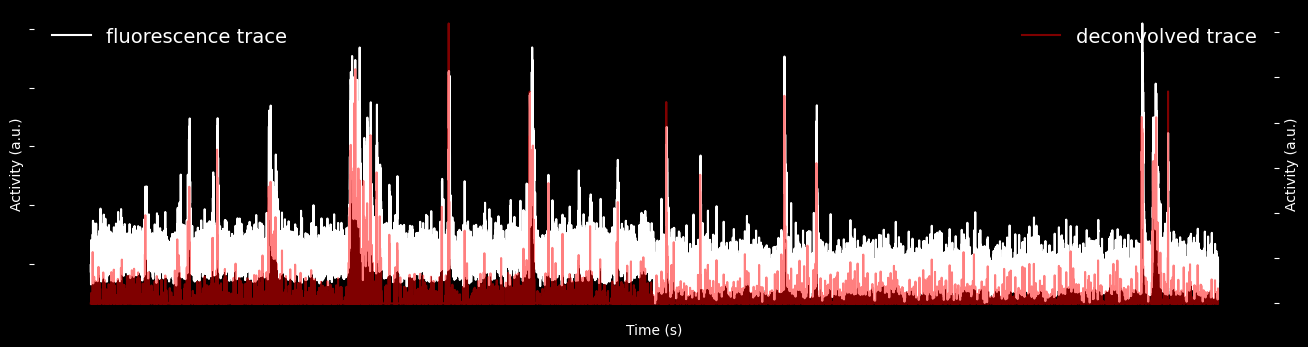

In [12]:
# TODO: prevent showing and just save. Make function
query_cells = (imaging.Segmentation.Mask * imaging.MaskClassification.MaskType & curation_key & 'mask_center_z=0' & 'mask_npix > 80').proj()

fluorescence_traces = (imaging.Fluorescence.Trace & query_cells).fetch('fluorescence', order_by='mask')

activity_traces = (imaging.Activity.Trace & query_cells).fetch('activity_trace', order_by='mask')

sampling_rate = (scan.ScanInfo & curation_key).fetch1('fps') # [Hz]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax2 = ax.twinx()

for f, a in zip(fluorescence_traces, activity_traces):
    ax.plot(np.r_[:f.size] * 1/sampling_rate, f, 'w', label='fluorescence trace')    
    ax2.plot(np.r_[:a.size] * 1/sampling_rate, a, 'r', alpha=0.5, label='deconvolved trace')
    
    break

ax.tick_params(labelsize=14)
ax2.tick_params(labelsize=14)

ax.legend(loc='upper left', prop={'size': 14})
ax2.legend(loc='upper right', prop={'size': 14})

ax.set_xlabel('Time (s)')
ax.set_ylabel('Activity (a.u.)')
ax2.set_ylabel('Activity (a.u.)');

In [11]:
imaging.Activity.Trace() & query_cells

NameError: name 'query_cells' is not defined

In [15]:
imaging.Fluorescence.Trace() * imaging.Segmentation.Mask() & query_cells

session_id,scan_id,paramset_idx,curation_id,mask,fluo_channel 0-based indexing,fluorescence fluorescence trace associated with this mask,neuropil_fluorescence Neuropil fluorescence trace,roi_group chronic recording same-cell-id. Defaults to 0. #TR23,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above
sess9FHS7Y22,scan9FHS7Y22,0,1,0,0,=BLOB=,=BLOB=,0,0,112,148,148,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,3,0,=BLOB=,=BLOB=,0,0,88,78,64,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,5,0,=BLOB=,=BLOB=,0,0,108,123,131,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,11,0,=BLOB=,=BLOB=,0,0,81,82,222,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,12,0,=BLOB=,=BLOB=,0,0,107,82,130,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,34,0,=BLOB=,=BLOB=,0,0,82,144,198,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [16]:
imaging.Segmentation.Mask()

session_id,scan_id,paramset_idx,curation_id,mask,roi_group chronic recording same-cell-id. Defaults to 0. #TR23,segmentation_channel 0-based indexing,mask_npix number of pixels in ROIs,mask_center_x center x coordinate in pixel,mask_center_y center y coordinate in pixel,mask_center_z center z coordinate in pixel,mask_xpix x coordinates in pixels,mask_ypix y coordinates in pixels,mask_zpix z coordinates in pixels,mask_weights weights of the mask at the indices above
sess9FHS7Y22,scan9FHS7Y22,0,1,0,0,0,112,148,148,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,1,0,0,73,82,192,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,2,0,0,105,170,54,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,3,0,0,88,78,64,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,4,0,0,69,74,176,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,5,0,0,108,123,131,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,6,0,0,65,88,192,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,7,0,0,53,170,212,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,8,0,0,58,70,191,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=
sess9FHS7Y22,scan9FHS7Y22,0,1,9,0,0,69,142,20,0,=BLOB=,=BLOB=,=BLOB=,=BLOB=


In [ ]:
from rastermap import Rastermap
from scipy import stats 
from scipy.ndimage import gaussian_filter1d

ops = {'n_components': 1, 'n_X': 100, 'alpha': 1., 'K': 1.,
            'nPC': 200, 'constraints': 2, 'annealing': True, 'init': 'pca',
            'start_time': 0, 'end_time': -1}

S = np.vstack(fluorescence_traces)
# we run rastermap the same way that the other scikit-learn embedding algorithms work
# model = Rastermap(n_components=1, n_X=100, verbose = True).fit(S) 
model = Rastermap(n_components=ops['n_components'], n_X=ops['n_X'], nPC=ops['nPC'],
                          init=ops['init'], alpha=ops['alpha'], K=ops['K'], constraints=ops['constraints'],
                          annealing=ops['annealing'])
model.fit(S)
def running_average(X, nbin = 10):
    Y = np.cumsum(X, axis=0)
    Y = Y[nbin:, :] - Y[:-nbin, :]
    return Y
# the manifold embedding is in model.embedding
isort = np.argsort(model.embedding[:,0])

# sort by embedding and smooth over neurons
# Sfilt = running_average(S[isort], 0)
Sfilt = gaussian_filter1d(S[isort].T, np.minimum(8,np.maximum(1,int(S.shape[0]*0.005))),axis=1)
Sfilt = stats.zscore(Sfilt, axis=0)



In [ ]:
plt.figure(figsize=(16,12))
plt.imshow(Sfilt, vmin = -0.1, vmax=3, aspect='auto', cmap='gray_r')
plt.xlabel('time points')
plt.ylabel('sorted neurons')
# plt.show()

also see https://github.com/trose-neuro/mini2p---moser-analysis-datajoint/blob/master/Analysis%20notebooks/PCA%20Stringer%20Pacchitariu.ipynb

In [ ]:
from adamacs.helpers import stack_helpers as sh

In [ ]:
from scipy.ndimage import mean
import tifffile
path = (scan.ScanPath & curation_key).fetch1("path") + ("/suite2p/plane0/reg_tif")

# path = '/datajoint-data/data/jisooj/RN_OPI-1681_2023-02-15_scan9FGLEFJ3_sess9FGLEFJ3/suite2p_exp9FGLEFJ3/suite2p/plane0/reg_tif'
# Get a list of all tiff files in the folder
tiff_files = [os.path.join(path, f) for f in natsorted(os.listdir(path)) if f.endswith('.tif')]

print(tiff_files)

# Load each tiff stack into a list of numpy arrays
stacks = []
for f in tiff_files:
    with tifffile.TiffFile(f) as tif:
        # Get the number of pages in the file
        num_pages = len(tif.pages)
        
        # Create a numpy array to store all pages
        stack = np.zeros((num_pages,) + tif.pages[0].shape, dtype=tif.pages[0].dtype)
        
        # Iterate over the pages and store them in the array
        for i, page in enumerate(tif.pages):
            stack[i] = page.asarray()

    stacks.append(stack)

# Concatenate the stacks into a single numpy array along the z-axis
volume = np.concatenate(stacks, axis=0)

# # delete registration tiffd
# for f in tiff_files:
#     os.remove(f) 

### moving average filter

In [ ]:
### moving average filter
# Create a running Z mean projection of the volume

runav = 60
# running_z_projection = uniform_filter_mt(volume, size=(runav,xyrunav,xyrunav))
running_z_projection = sh.rolling_average_filter_mt(volume, runav)

In [ ]:
sh.display_volume_z(running_z_projection,1)

### mp4 movie generaltion

In [ ]:
filename = os.path.join(path, 'registered_movie' + str(runav) + '_frame_runningaverage' + '.mp4')

fps = 240   # frames per second - 120 default
p1 = 1      # percentile scaling low - 1 default
p2 = 99.995  # percentile scaling high - 99.995 default

rescaled_image_8bit = sh.make_stack_movie(running_z_projection, filename, fps, p1, p2)

## Exploring updates

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging.Processing) + dj.Diagram(imaging.Curation) + dj.Diagram(imaging.Curation)

In [ ]:
dj.Diagram(subject.Subject) + dj.Diagram(session.Session) + dj.Diagram(scan) + dj.Diagram(imaging)

In [ ]:
imaging.MotionCorrection.Summary()
